In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
"""
Explore the frequency domain features for the crowdsignals dataset in more detail,
consider the individual frequencies for the different measurements and see whether you can find interesting patterns.
Do you see consistent amplitudes of certain frequencies during the same activities?
And how do the amplitudes differ for the different activities?
"""

ch2_results = pd.read_csv("./intermediate_datafiles/chapter2_result.csv")
ch4_results = pd.read_csv("./intermediate_datafiles/chapter4_result.csv")

In [4]:
ch4_results["acc_watch_x_freq_0.0_Hz_ws_40"]

activities = [c for c in ch2_results.columns if "label" in c]
print(activities)
activities = ["labelRunning", "labelWalking", "labelOnTable", "labelSitting"]
activities.sort()

['labelOnTable', 'labelSitting', 'labelWashingHands', 'labelWalking', 'labelStanding', 'labelDriving', 'labelEating', 'labelRunning']


In [5]:
# ch2_results.columns
cols = ["acc_phone_x", "acc_phone_y", "acc_phone_z", "gyr_phone_x", "gyr_phone_y", "gyr_phone_z"]
fig_outputs = "./figures/crowdsignals_ch4_analysis/"
os.makedirs(fig_outputs, exist_ok=True)

"""
walking usually with a frequency in the order of 1Hz (between 1 and 1.5 Hz)
"""

for col in cols:
    freq_cols = [c for c in ch4_results.columns if col+"_freq_" in c and not "weighted" in c]
    freq_cols.sort()
    freq_cols = freq_cols[1:]
    hz = [c.split("_freq_")[-1].split("_")[0] for c in freq_cols]
    
    if len(freq_cols) > 0:
        print(col, "has", len(freq_cols), "frequencies")
        
        figparams = dict(figsize=(8, 5), dpi=300)
        
        def agg_single_measurement_by_activity(activity, measures, agg="mean"):
            amps = ch4_results[ch4_results[activity] == 1.0][measures].fillna(0.0)
            if agg in ["std", "standard deviation"]: return amps.abs().std().max()
            elif agg == "mean": return amps.abs().mean().max() # .abs()
            raise ValueError("agg must be one of std or mean")
        
        # mean amplitudes for different activities in comparison to each other
        for agg in ["mean", "standard deviation"]:
            fig, ax = plt.subplots(1,**figparams)
            bins = [(freq * len(activities)) for freq in range(len(hz))]
            norm_amplitude = 0
            for a in activities:
                norm_amplitude = max(
                    norm_amplitude,
                    agg_single_measurement_by_activity(a, freq_cols, agg=agg))

            for offset, activity in enumerate(activities):
                pos = [b + offset for b in bins]
                amps = [abs(
                    agg_single_measurement_by_activity(activity, c, agg=agg) / norm_amplitude
                ) for c in freq_cols]
                plt.bar(pos, amps, label=activity)

            ax.set_xticks(bins)
            ax.set_xticklabels(hz)
            ax.set_ylim([0, 1.])
            plt.xlabel("frequency (Hz)")
            plt.ylabel("absolute normalized amplitude")
            plt.legend()
            plt.title("%s normalized amplitutes %s" % (agg, col))
            plt.tight_layout()
            plt.savefig(os.path.join(fig_outputs, "amplitutes_%s_%s.pdf" % (agg, col)))
            plt.close()
        
        def agg_measurement_by_activity(activity, measure, agg="mean"):
            amps = ch4_results[ch4_results[activity] == 1.0][measure].fillna(0.0)
            norm_amplitude = 0
            for a in activities:
                norm_amplitude = max(
                    norm_amplitude,
                    agg_single_measurement_by_activity(a, freq_cols, agg=agg))
            # norm_freqs = ch4_results[ch4_results[activity] == 1.0][freq_cols].fillna(0.0)
            # ch4_results[ch4_results[activities].sum(axis=1) > 0]
            # norm_freqs = ch4_results[ch4_results[activities].sum(axis=1) > 0][freq_cols].fillna(0.0)
            if agg in ["std", "standard deviation"]:
                return abs(amps.std() / norm_amplitude) # norm_freqs.std().max()) # .abs()
            elif agg == "mean":
                return abs(amps.mean() / norm_amplitude) # norm_freqs.mean().max()) # .abs()
            raise ValueError("agg must be one of std or mean")
        
        # stddev of each freq for a given activity and measurement
        for agg in ["mean", "standard deviation"]:
            for _, activity in enumerate(activities):
                fig, ax = plt.subplots(1,**figparams)
                plt.bar(hz, [agg_measurement_by_activity(activity, c, agg=agg) for c in freq_cols], label=activity)
                ax.set_ylim([0, 1.])
                plt.title("%s of normalized frequency amplitudes for %s" % (agg, col))
                plt.xlabel("frequency (Hz)")
                plt.ylabel("absolute normalized amplitude")
                plt.legend()
                plt.tight_layout()
                plt.savefig(os.path.join(fig_outputs, "%s_%s_%s.pdf" % (agg, col, activity)))
                plt.close()

acc_phone_x has 20 frequencies
acc_phone_y has 20 frequencies
acc_phone_z has 20 frequencies
gyr_phone_x has 20 frequencies
gyr_phone_y has 20 frequencies
gyr_phone_z has 20 frequencies


In [6]:
from util.VisualizeDataset import VisualizeDataset
DataViz = VisualizeDataset(os.path.abspath(''))

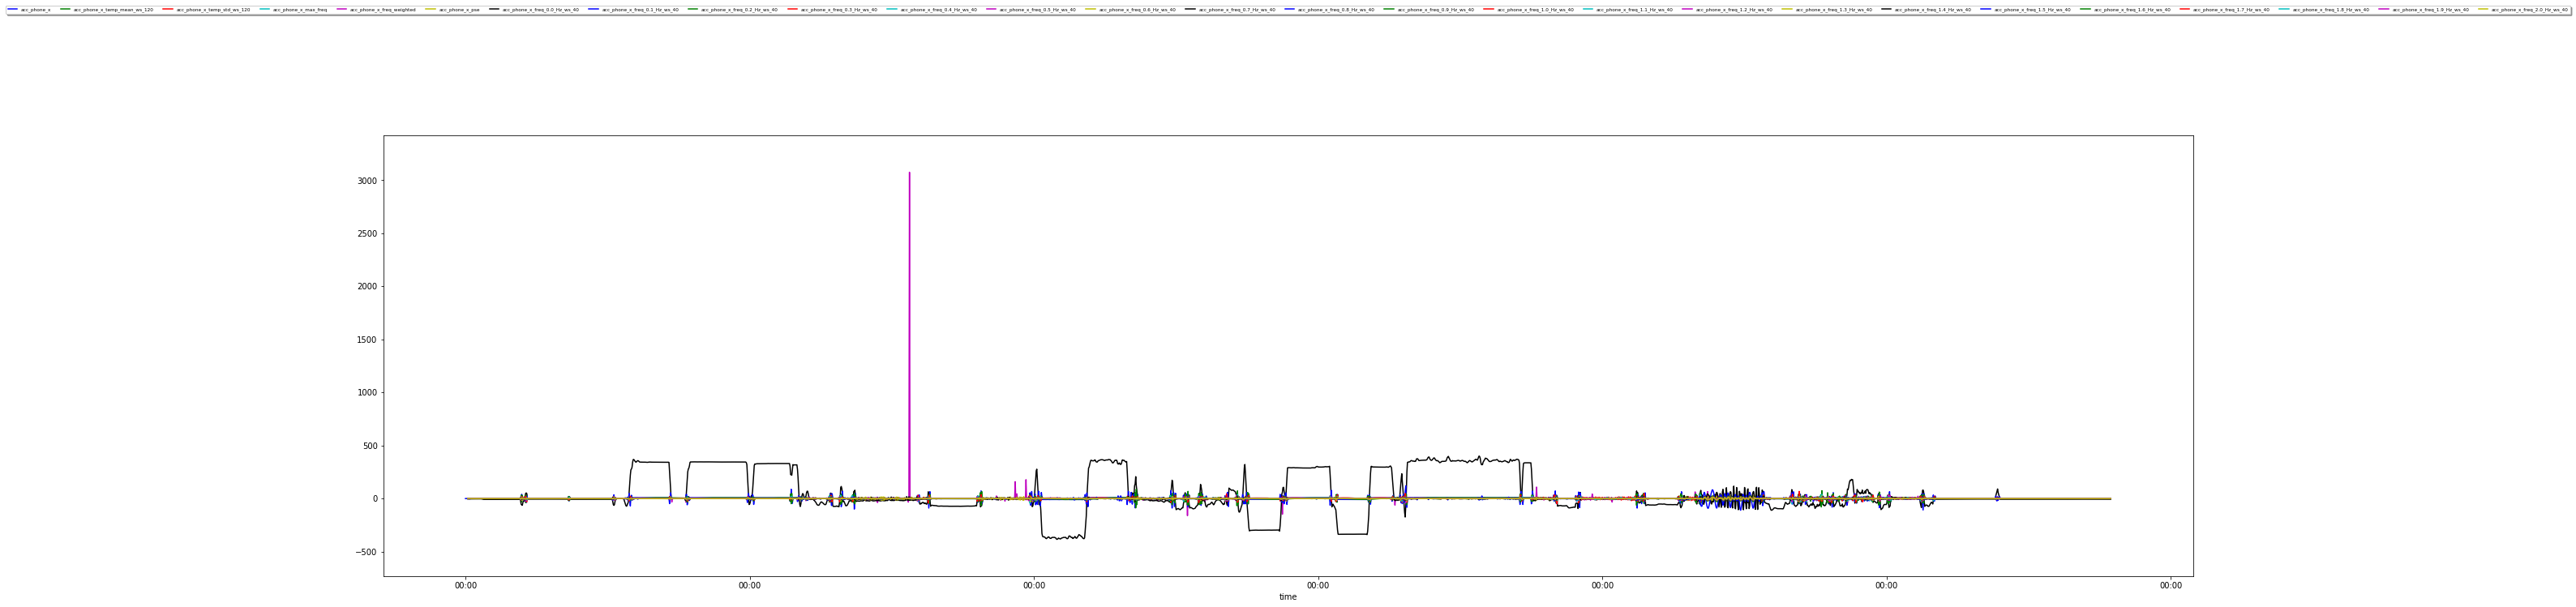

In [7]:
DataViz.plot_dataset(ch4_results, ["acc_phone_x",], ["like",], ["line"], save=False, figsize=(40,10))

In [26]:
ch4_results_new = ch4_results.copy()
ch4_results_new = ch4_results_new.iloc[:100]
acc_data = ["acc_phone_x", "acc_phone_y", "acc_phone_z"]

window_size = 10
sma_temp = []

def test_agg_func(acc):
    print(ch4_results_new.index)
    print(acc.index)
    sacc = ch4_results_new.loc[acc.index][acc_data].copy()
    assert sacc.shape == (window_size, 3)
    transformation = np.fft.rfft(sacc.T.to_numpy(), len(sacc)) # , axis=0)
    real_ampl = pd.DataFrame(transformation.real)
    assert real_ampl.shape[0] == 3
    
    # compute signal magnitude area
    sma = real_ampl.abs().sum().sum()/3
    sma_temp.append(sma)
    return 0
    
print(ch4_results_new.shape)
ch4_results_new[acc_data[0]].rolling(window_size).apply(test_agg_func, raw=False)
print(sma_temp)

(100, 542)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=0, stop=10, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=1, stop=11, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=2, stop=12, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=3, stop=13, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=4, stop=14, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=5, stop=15, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=6, stop=16, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=7, stop=17, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=8, stop=18, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=9, stop=19, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=10, stop=20, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=11, stop=21, step=1)
RangeIndex(start=0, stop=100, step=1)
RangeIndex(start=12, stop=22, step=1)
RangeIndex(